In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
import gc; gc.enable()


%matplotlib inline

In [2]:
df = pd.read_csv('./data/data.csv')

In [3]:
df=df.rename(columns = {"Unnamed: 0": "Date"})

In [4]:
df.tail()

,Date,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
145915,2017-04-24 19:00:00,16984.175000,1291.972222,1768.647222,654.152778,1058.680556,1062.383333,2238.380556,855.547222,289.441667,5559.388889,487.286111,1718.294444,NaN
145916,2017-04-24 20:00:00,17615.657540,1341.735714,1843.365873,683.256349,1108.247222,1122.049603,2388.324206,884.457540,311.366270,5647.025397,498.217460,1787.611905,NaN
145917,2017-04-24 21:00:00,17200.752778,1290.469444,1801.922222,675.925000,1091.652778,1086.563889,2318.411111,846.966667,290.966667,5521.511111,492.600000,1783.763889,NaN
145918,2017-04-24 22:00:00,16148.388889,1193.955556,1687.572222,641.322222,1011.200000,1007.902778,2140.886111,776.563889,258.008333,5256.850000,475.905556,1698.222222,NaN
145919,2017-04-24 23:00:00,14931.883333,1092.930556,1577.530556,583.055556,933.863889,920.994444,1937.283333,699.247222,231.258333,4895.633333,460.969444,1599.116667,NaN


In [5]:
df.Date = pd.to_datetime(df.Date)

In [6]:
df.set_index('Date', inplace = True)

In [7]:
df.sort_index(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145920 entries, 2003-01-01 00:00:00 to 2019-07-31 23:00:00
Data columns (total 13 columns):
Load             145290 non-null float64
CAPITL           145290 non-null float64
CENTRL           145290 non-null float64
DUNWOD           145290 non-null float64
GENESE           145290 non-null float64
HUD VL           145290 non-null float64
LONGIL           127065 non-null float64
MHK VL           145290 non-null float64
MILLWD           145290 non-null float64
N.Y.C.           127065 non-null float64
NORTH            145290 non-null float64
WEST             145290 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 15.6 MB


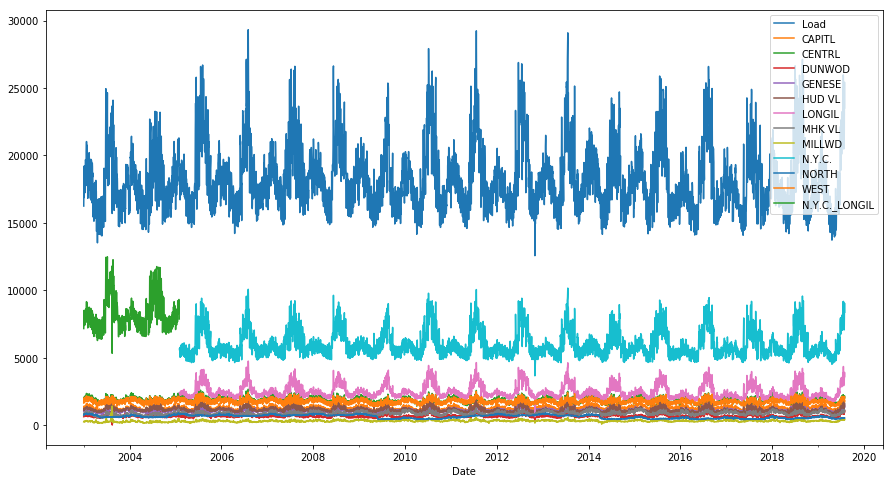

In [9]:
days = df.resample("D")
days_=days.mean()
days_.plot(kind = 'line', figsize=(15, 8))
plt.show()

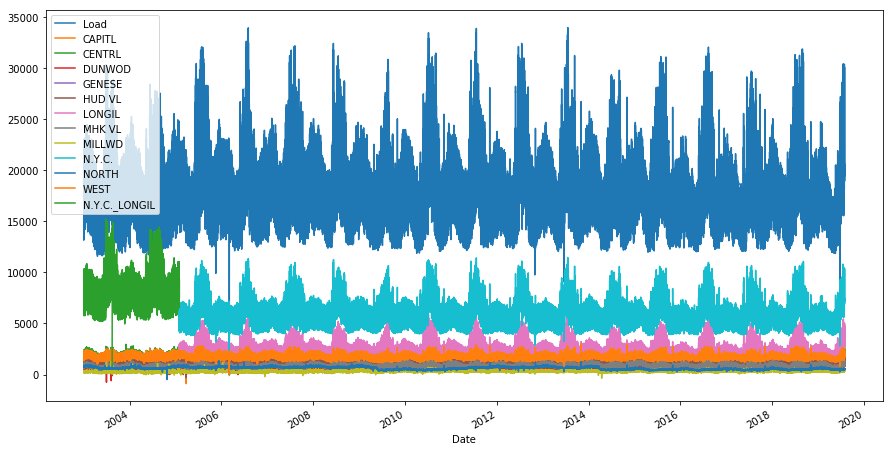

In [10]:
df.plot(kind = 'line', figsize=(15, 8))
plt.show()

In [11]:
df.tail()

,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
Date,,,,,,,,,,,,,
2019-07-31 19:00:00,24835.000000,1947.066667,2294.158333,964.691667,1518.908333,1498.525000,3807.300000,1143.666667,430.083333,8408.100000,585.041667,2237.458333,NaN
2019-07-31 20:00:00,24219.675000,1896.200000,2219.283333,948.775000,1435.250000,1473.858333,3710.075000,1124.775000,435.516667,8286.316667,550.741667,2138.883333,NaN
2019-07-31 21:00:00,23578.041667,1842.125000,2147.391667,921.316667,1390.575000,1420.908333,3560.058333,1093.925000,423.700000,8140.341667,539.916667,2097.783333,NaN
2019-07-31 22:00:00,22177.316667,1699.375000,1982.983333,867.841667,1269.191667,1321.225000,3282.200000,1007.658333,387.158333,7849.108333,518.491667,1992.083333,NaN
2019-07-31 23:00:00,20562.291667,1551.416667,1798.033333,803.283333,1161.616667,1214.883333,2986.000000,914.350000,352.566667,7434.916667,514.658333,1830.566667,NaN


In [12]:
def get_slope(y):
    x = range(len(y))
    slope = np.polyfit(x, y, 1)[0]
    return slope

In [13]:
def get_acceleration(y):
    x = range(len(y))
    acc = 0.5*np.polyfit(x, y, 2)[0]
    return acc

In [14]:
def cyc_feats(df, feat):
    start = df.index[0].date().year-1
    df['cyc_{0}_x'.format(str(feat))] = np.cos(((2*np.pi)/df[feat])*(df['year']-(start))) #x-coord
    df['cyc_{0}_y'.format(str(feat))] = np.sin(((2*np.pi)/df[feat])*(df['year']-(start))) #y-coord
    return df

In [93]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    for i in [14, 28, 60]:
        df['MA_{0}'.format(str(i))] = df['Load'].rolling(24*i).mean() # rolling average
        df['MMAX_{0}'.format(str(i))] = df['Load'].rolling(24*i).max() # rolling maximum
        df['MMIN_{0}'.format(str(i))] = df['Load'].rolling(24*i).min() # rolling minimum
        df['MSTD_{0}'.format(str(i))] = df['Load'].rolling(24*i).std() # rolling standard deviation
        df['MSLOPE_{0}'.format(str(i))] = df['Load'].rolling(24*i).apply(lambda x: get_slope(x), raw=True) # rolling slope
        df['MACC_{0}'.format(str(i))] = df['Load'].rolling(24*i).apply(lambda x: get_acceleration(x),raw=True) # rolling acceleration
    for i in [1, 7, 30, 60, 90, 180]:
        # add the lagged Load as a feature
        df['lag_{0}'.format(str(i))] = df['Load'].shift(24*i)
        # as well as the percentage of the current Load for each lagged closing price
        df['pct_{0}'.format(str(i))] = df['lag_{0}'.format(str(i))] / df['Load']
   
    #create cyclical features
#     feats = ['month', 'dayofmonth', 'dayofyear', 'weekofyear']
#     for feat in feats:
#         df = cyc_feats(df, feat)
    return df

In [94]:
def split_data(data, start_date, split_date):
    return data[(start_date) : (split_date)].copy(), \
               data[data.index >  split_date].copy()

In [95]:
def data_prep(data, isTest=0):
    used_cols = [col for col in data.columns.tolist() if col not in [target, _id]]
    keep_cols = used_cols
    if isTest:
        pass
    else:
        keep_cols += [target]
    used_cols = [col for col in keep_cols if col not in [target, _id]]
    return data[keep_cols].copy(), keep_cols, used_cols

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145290 entries, 2003-01-01 00:00:00 to 2019-07-31 23:00:00
Data columns (total 1 columns):
Load    145290 non-null float64
dtypes: float64(1)
memory usage: 7.2 MB


In [97]:
df.isna().sum()

Load    0
dtype: int64

In [98]:
#drop NaNs
target = 'Load'
df.dropna(subset = [target], inplace=True)
df.isna().sum()

Load    0
dtype: int64

In [99]:
df.shape

(145290, 1)

In [100]:
drop_cols = [col for col in df.columns.tolist() if col not in [target]]

In [101]:
df.drop(drop_cols, axis=1, inplace=True)

In [102]:
train, test = split_data(df,'01-01-2014', '01-01-2019')

In [103]:
train = create_features(train)

In [104]:
test = create_features(test)

In [105]:
_id = 'date'
train, keep_cols, used_cols = data_prep(train)
test, keep_cols, used_cols = data_prep(test)

In [106]:
X_train = train[used_cols].copy().fillna(0)
y_train = train[target].copy()
X_test = test[used_cols].copy().fillna(0)
y_test = test[target].copy()

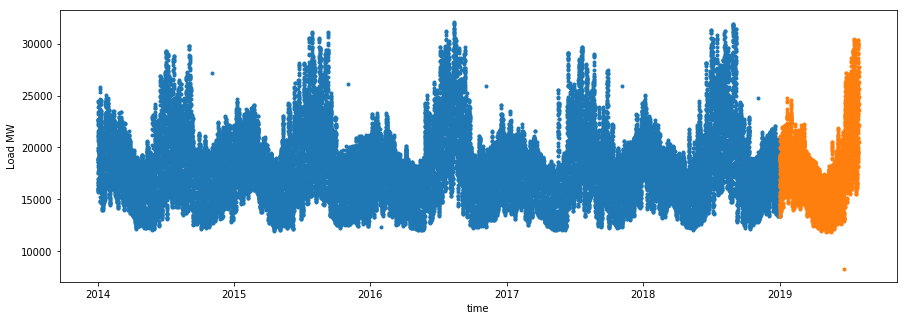

In [107]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('Load MW')
plt.plot(X_train.index,y_train, '.')
plt.plot(X_test.index,y_test, '.')
plt.show()

In [108]:
X_train.shape

(43843, 38)

In [109]:
X_test.shape

(5086, 38)

In [110]:
X_train.shape, y_train.shape

((43843, 38), (43843,))

In [111]:
X_test.shape

(5086, 38)

In [112]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [113]:
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        early_stopping_rounds=50, 
        verbose=False) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

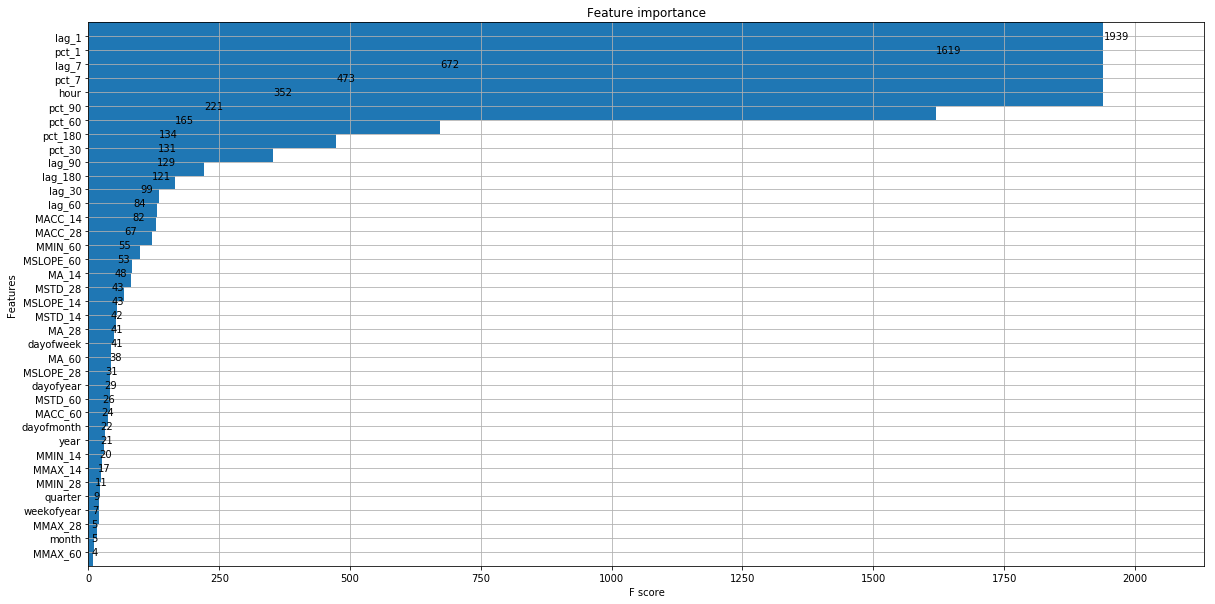

In [114]:
plt.rcParams["figure.figsize"] = (20, 10)
xgb.plot_importance(reg, height=10)

In [115]:
# feats = reg.get_booster().get_score(importance_type="weight")
# feats

In [116]:
y_pred = reg.predict(X_test)


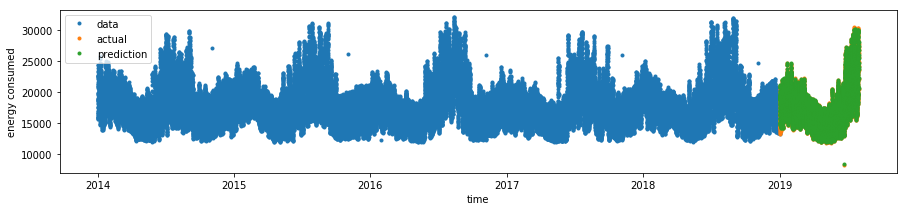

In [117]:
plt.figure(figsize=(15,3))
plt.xlabel('time')
plt.ylabel('energy consumed')
plt.plot(X_train.index, y_train, '.', label='data')
plt.plot(X_test.index, y_test, '.', label='actual')
plt.plot(X_test.index, y_pred, '.', label='prediction')
plt.legend()
# plt.xlim(left=date_from, right=date_to)
plt.show()

In [155]:
def plot_(data, target, begin, end, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(begin, end))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('energy consumed')
    plt.plot(data.index, target, '-', label='data')
    plt.plot(X_test.index, y_pred, '.', label='prediction')
    plt.legend()
    plt.xlim(left=begin, right=end)

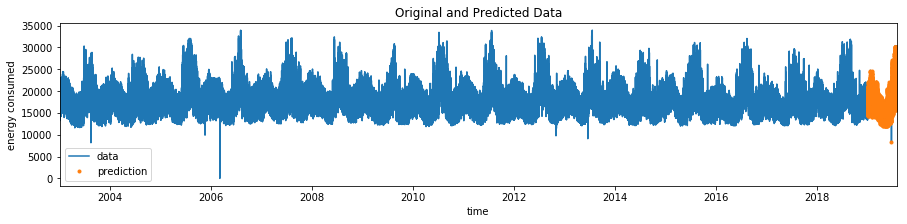

In [156]:
plot_(df, df['Load'], df.index[0].date(), df.index[-1].date(), 'Original and Predicted Data')

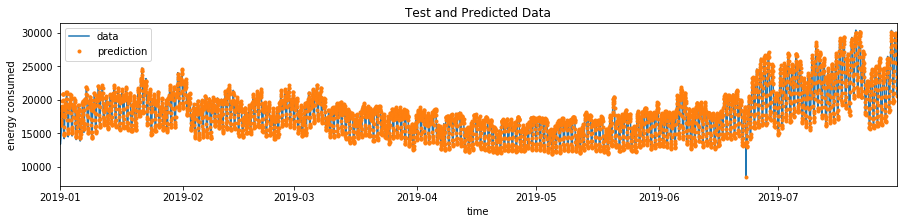

In [157]:
plot_(X_test, y_test, y_test.index[0].date(), y_test.index[-1].date(), 'Test and Predicted Data')

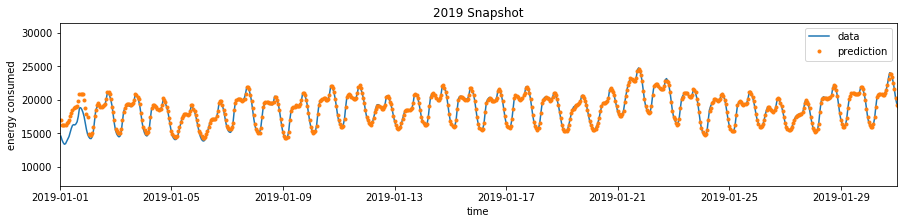

In [158]:
plot_(X_test, y_test, '01-01-2019', '01-31-2019', '2019 Snapshot')


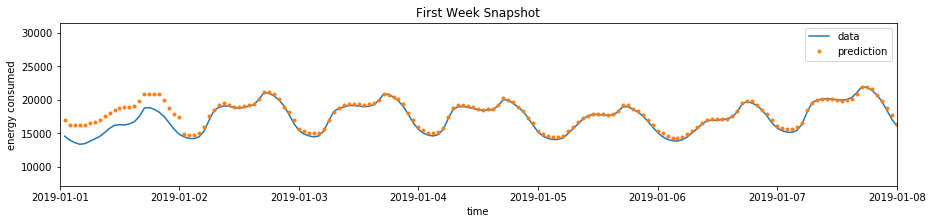

In [159]:
plot_(X_test, y_test, '01-01-2019', '01-08-2019', 'First Week Snapshot')


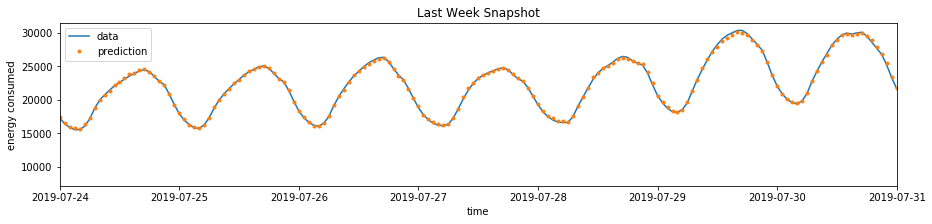

In [160]:
plot_(X_test, y_test, '07-24-2019', '07-31-2019', 'Last Week Snapshot')

In [161]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from numba import jit
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [162]:
def forecast_error(y_true, y_pred):
    return y_true - y_pred

In [125]:
def mean_forecast_error(forecast_error):
    return forecast_error.mean()

In [126]:
def smape(A, F):
    return (100/len(A)) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [127]:
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

In [128]:
MSE = mean_squared_error(y_test, y_pred)
print(MSE)

39688.01356595969


In [129]:
MAE = mean_absolute_error(y_test, y_pred)
print(MAE)

85.97772279489908


In [130]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
print(MAPE)

0.4872921752747667


In [131]:
sMAPE = smape(y_test, y_pred)
print(sMAPE)

0.4809065112439466


In [132]:
RMSE = np.sqrt(MSE)
print(RMSE)

199.21850708696644


In [133]:
FE = forecast_error(y_test, y_pred)
MFE = mean_forecast_error(FE)
print(MFE)

-27.14747801453217


In [134]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

0.9964601575829398


In [135]:
sMAPE_2 = smape_fast(y_test, y_pred)
print(sMAPE_2)

0.48090651124394695
